# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import gc
import time
import random
import re
from tqdm import tqdm 
import os
import json

def read_json(filepath: str) -> dict:
    with open(filepath, "r") as f:
        return json.load(f)
    
def read_jsonl(filepath: str) -> dict:
    data = []
    with open(filepath, "r") as f:
        for line in f.readlines():
            example = json.loads(line)
            data.append(example)
    return data

def write_jsonl(data: list, filepath: str) -> None:
    with open(filepath, "w") as f:
        for example in data:
            f.write(json.dumps(example) + "\n")
            
delim = "|"

In [2]:
!ls "/nethome/dhe83/mice/experiments/WiC/1|32|100/1|2|16"

alpaca-7b_masked_bos  opt-1.3b	opt-6.7b
llama-7b	      opt-2.7b	prompt_map.json
opt-125m	      opt-350m	similarity_scores.json


# Functions

## Reading Data

In [3]:
def get_examples(inference_dir):
    examples = {}
    for f in os.listdir(inference_dir):
        f_path = os.path.join(inference_dir, f)
        if os.path.isdir(f_path):
            predictions_path = os.path.join(f_path, "predictions.json")
            predictions = read_json(predictions_path)
            examples[f] = predictions
    return examples

def parse_examples(examples):
    parsed = {}
    for test_id, preds in examples.items():
        parsed[test_id] = {}
        for in_context, res in preds.items():
            parsed[test_id][in_context] = res['prediction'] 
    return parsed
        
labels = {}
def get_labels(task):
    data = read_jsonl(os.path.join("/nethome/dhe83/mice/data", task, "val.jsonl"))
    data = {str(ex['idx']): ex['label'] for ex in data}
    return data

def get_similarity_scores(gen_dir):
    similarity_scores = read_json(os.path.join(gen_dir,"similarity_scores.json"))
    return {test_id:{str(pair[0]): pair[1] for pair in scores} for test_id, scores in similarity_scores.items()}

## Processing

In [38]:
def true_probs(examples):
    probs = {}
    for test_id, preds in examples.items():
        n = len(preds.values())
        true = float(sum([1 for x in preds.values() if x]))
        probs[test_id] = true / n    
    return probs

def matching_probs(examples, labels):
    probs = {}
    for test_id, preds in examples.items():
        n = len(preds.values())
        label = labels[test_id]
        matching = float(sum([1 for x in preds.values() if x == label]))
        probs[test_id] = matching / n    
    return probs

def oracle(examples, labels):
    correct = 0
    for test_id, preds in examples.items():
        if labels[test_id] in preds.values():
            correct+=1
    return correct/len(examples)

def in_context_stats(examples, labels):
    correct = {}
    totals = {}
    for test_id, preds in examples.items():
        label = labels[test_id]
        for train_ids, pred in preds.items():
            if train_ids not in totals:
                totals[train_ids] = 0
                correct[train_ids] = 0
            totals[train_ids]+=1
            if pred == label:
                correct[train_ids]+=1
                
    probs = {k: float(correct[k])/v for k, v in totals.items()}
    return probs, totals 

def inflate(probs):
    '''Only works for two train examples'''
    res = {}
    for k, v in probs.items():
        a, b = k.split(delim)
        if a not in res:
            res[a] = {}
        res[a][b] = v
    return res

## Plotting

In [5]:
def prob_hist(probs):
    plt.hist(probs, bins=16)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Correct Probabilities')
    plt.show()
    
def pair_visualization(idx_map, title):
    demonstrations = {x for idx in idx_map.keys() for x in idx.split(delim)}
    N = len(demonstrations)
    grid = torch.zeros((N, N))

    stoi = {s:i for i, s in enumerate(demonstrations)}
    itos = {s:i for i, s in stoi.items()}

    for k, v in idx_map.items():
        ids = k.split(delim)
        grid[stoi[ids[1]]][stoi[ids[0]]] = v


    fig, ax = plt.subplots()
    im = ax.imshow(grid, cmap="Greens")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(demonstrations)), labels=demonstrations)
    ax.set_yticks(np.arange(len(demonstrations)), labels=demonstrations)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

# Runs

In [15]:
task = "WiC"
exp_dir = "1|32|100"
gen_dir = "1|2|16"
model = "llama-7b"

In [16]:
inference_dir = os.path.join("/nethome/dhe83/mice/experiments/", task, exp_dir, gen_dir, model) 

In [17]:
examples = get_examples(inference_dir)

In [18]:
parsed = parse_examples(examples)

In [30]:
if task not in labels:
    labels[task] = get_labels(task)

In [31]:
sum([1 for x in labels[task].values() if x]) / len(labels[task].values())

0.5

In [32]:
true_probs(parsed)

{'330': 1.0,
 '55': 0.5,
 '474': 0.8125,
 '302': 1.0,
 '195': 1.0,
 '224': 1.0,
 '410': 1.0,
 '168': 1.0,
 '422': 1.0,
 '552': 0.625,
 '115': 0.625,
 '522': 1.0,
 '211': 0.8125,
 '288': 1.0,
 '157': 1.0,
 '198': 0.5625,
 '436': 1.0,
 '17': 0.8125,
 '208': 1.0,
 '632': 0.6875,
 '574': 0.9375,
 '144': 1.0,
 '139': 0.9375,
 '404': 1.0,
 '52': 1.0,
 '247': 1.0,
 '137': 0.75,
 '4': 1.0,
 '56': 1.0,
 '172': 0.75,
 '301': 0.75,
 '13': 0.75,
 '563': 1.0,
 '464': 1.0,
 '569': 0.75,
 '357': 0.8125,
 '617': 0.75,
 '250': 1.0,
 '227': 1.0,
 '77': 1.0,
 '365': 0.8125,
 '381': 0.75,
 '628': 1.0,
 '281': 1.0,
 '265': 0.75,
 '386': 0.875,
 '368': 1.0,
 '48': 0.875,
 '220': 0.625,
 '129': 0.75,
 '69': 0.8125,
 '371': 1.0,
 '191': 0.875,
 '108': 1.0,
 '538': 0.875,
 '102': 0.9375,
 '26': 0.8125,
 '500': 1.0,
 '440': 1.0,
 '437': 0.8125,
 '85': 0.8125,
 '341': 1.0,
 '523': 0.875,
 '459': 0.9375,
 '72': 0.75,
 '317': 0.9375,
 '96': 1.0,
 '325': 0.9375,
 '255': 0.8125,
 '258': 0.9375,
 '75': 0.875,
 '429':

In [40]:
match_probs = matching_probs(parsed, labels[task])

In [42]:
sorted(list(match_probs.items()), key=lambda x:x[1])

[('330', 0.0),
 ('302', 0.0),
 ('195', 0.0),
 ('224', 0.0),
 ('168', 0.0),
 ('422', 0.0),
 ('157', 0.0),
 ('436', 0.0),
 ('208', 0.0),
 ('247', 0.0),
 ('4', 0.0),
 ('56', 0.0),
 ('250', 0.0),
 ('227', 0.0),
 ('628', 0.0),
 ('281', 0.0),
 ('368', 0.0),
 ('500', 0.0),
 ('96', 0.0),
 ('170', 0.0),
 ('213', 0.0),
 ('167', 0.0),
 ('515', 0.0),
 ('248', 0.0),
 ('534', 0.0),
 ('574', 0.0625),
 ('139', 0.0625),
 ('102', 0.0625),
 ('459', 0.0625),
 ('408', 0.0625),
 ('251', 0.0625),
 ('386', 0.125),
 ('48', 0.125),
 ('191', 0.125),
 ('523', 0.125),
 ('29', 0.125),
 ('491', 0.125),
 ('474', 0.1875),
 ('211', 0.1875),
 ('357', 0.1875),
 ('365', 0.1875),
 ('85', 0.1875),
 ('122', 0.1875),
 ('401', 0.1875),
 ('301', 0.25),
 ('13', 0.25),
 ('72', 0.25),
 ('632', 0.3125),
 ('552', 0.375),
 ('220', 0.375),
 ('198', 0.4375),
 ('299', 0.4375),
 ('55', 0.5),
 ('57', 0.5),
 ('338', 0.5),
 ('8', 0.5625),
 ('115', 0.625),
 ('465', 0.625),
 ('18', 0.625),
 ('429', 0.6875),
 ('190', 0.6875),
 ('137', 0.75),
 

In [257]:
oracle(parsed, labels[task])

0.95

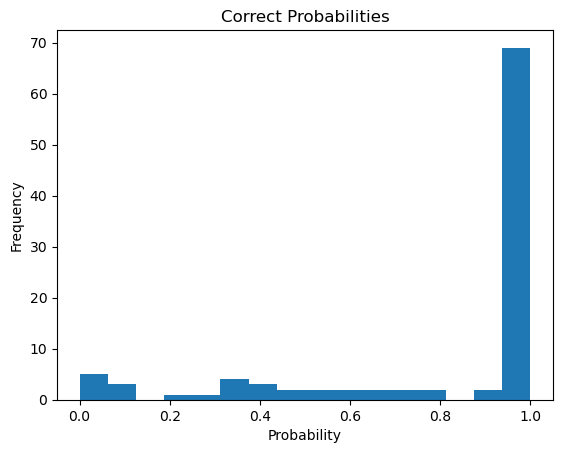

In [258]:
prob_hist(matching_probs.values())

In [259]:
icprobs, ictotals = in_context_stats(parsed, labels[task])

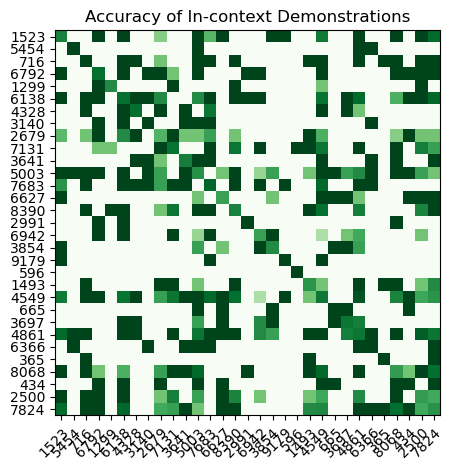

In [260]:
pair_visualization(icprobs, "Accuracy of In-context Demonstrations")

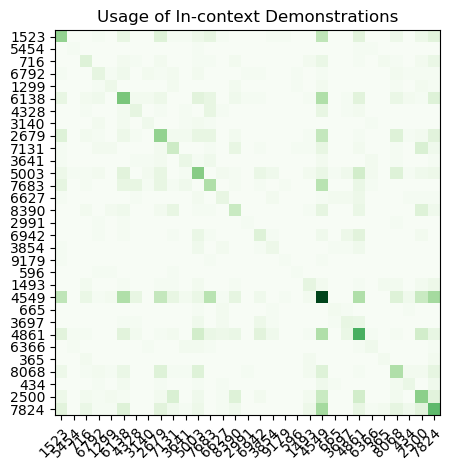

In [261]:
pair_visualization(ictotals, "Usage of In-context Demonstrations")

In [262]:
gen_dir = os.path.join("/nethome/dhe83/mice/experiments/", task, exp_dir, gen_dir) 

In [275]:
get_similarity_scores(gen_dir)

{'17': {'4861': 0.5885112285614014,
  '2500': 0.5345275402069092,
  '1523': 0.5322527885437012,
  '7824': 0.519047200679779,
  '2679': 0.5092442035675049,
  '4549': 0.5010762810707092,
  '6138': 0.49790191650390625,
  '7683': 0.49428436160087585,
  '7131': 0.4598652124404907,
  '8068': 0.4263431429862976,
  '6942': 0.42275992035865784,
  '4328': 0.4206773042678833,
  '5003': 0.41920554637908936,
  '716': 0.4031822979450226,
  '8390': 0.3965831696987152,
  '434': 0.3679662346839905,
  '9179': 0.3595179617404938,
  '6627': 0.3552654981613159,
  '3697': 0.34973204135894775,
  '6792': 0.3465040326118469,
  '1493': 0.3304198980331421,
  '3641': 0.28881698846817017,
  '1299': 0.2856437861919403,
  '5454': 0.2773694396018982,
  '2991': 0.2705729007720947,
  '3140': 0.22759664058685303,
  '3854': 0.2054262012243271,
  '596': 0.18252895772457123,
  '665': 0.08072923123836517,
  '6366': 0.07658711075782776,
  '5876': 0.03861379623413086,
  '365': -0.085593581199646},
 '19': {'4549': 0.3746231198

In [276]:
ic_similarities = {idxs: sum() for idxs in ic_probs.keys()}
for ic_p

{'4549|4549': 0.8275862068965517,
 '4549|6138': 0.8421052631578947,
 '4549|1493': 0.5,
 '4549|4861': 1.0,
 '6138|4549': 0.8421052631578947,
 '6138|6138': 0.8571428571428571,
 '6138|1493': 0.0,
 '6138|4861': 1.0,
 '1493|4549': 0.5,
 '1493|6138': 0.0,
 '1493|1493': 0.7142857142857143,
 '1493|4861': 1.0,
 '4861|4549': 0.9473684210526315,
 '4861|6138': 0.875,
 '4861|1493': 1.0,
 '4861|4861': 0.8285714285714286,
 '1523|1523': 0.7916666666666666,
 '1523|7824': 0.875,
 '1523|6138': 1.0,
 '1523|4549': 0.8125,
 '7824|1523': 0.875,
 '7824|7824': 0.71875,
 '7824|6138': 0.8888888888888888,
 '7824|4549': 0.7142857142857143,
 '6138|1523': 1.0,
 '6138|7824': 0.8888888888888888,
 '4549|1523': 0.8125,
 '4549|7824': 0.7619047619047619,
 '2679|2679': 0.5833333333333334,
 '2679|5003': 0.6666666666666666,
 '2679|8068': 0.6666666666666666,
 '2679|1523': 0.4444444444444444,
 '5003|2679': 0.5,
 '5003|5003': 0.7307692307692307,
 '5003|8068': 0.8888888888888888,
 '5003|1523': 1.0,
 '8068|2679': 0.44444444444444

In [ ]:
# Will need to correlation between prob of correct answer and similarity score